Цель исследования - создать две прогнозные модели для отбора бурёнок в поголовье:
* спрогнозировать возможный удой коровы (целевой признак Удой);
* рассчитать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).


План работ:

1. Предобработка данных
1.1. Подгрузить данные (возможно, объединить их в единый фрейм)
1.2. Посмотреть на пропуски в разных столбцах, и если таковых немного удалить
1.3. В оставшихся пропусках попробовать заполнить логически
1.4. Удалить явные дубликаты
1.5. Преобразовать типы данных
1.6. Обработать категориальные столбцы
1.7. Посмотреть на неявные дубликаты


2. Провести анализ данных
2.1. Построить графики признаков и посмотреть на распределения (только не знаю пока что с этой информацией делать)
2.2. Обработать выбросы
2.3. Рассмотреть на взаимосвзь между признаками друг с другом и между признаками и целевой переменной


3. Построить модели
3.1. линейной регрессии для прогнозирования удоя
3.1.1. необходимо отобрать наиболее статистически значимые признаки:
- либо на основе связи с целевой переменной
- либо попробовать перебрать все сочетания признаков и выбрать лучшую по R^2
3.1.2. оценить качество модели с помощи метрик
3.1.3. спрогнозировать удой

3.2. логистической регрессии для модели классификации
3.2.1. проанализировать на ошибки первого и второго родов и свести их к минимуму
3.2.2. спрогнозитровать вкус молока


4. Сделать итоговые выводы

## Загрузка данных

In [88]:
#pip install seaborn
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import datetime as dt
import seaborn as sns

import scipy.stats as st
from scipy.stats import binom, norm
#from scipy import stats as st

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
ferma_main = pd.read_csv('ferma_main.csv', sep = ';')
ferma_dad = pd.read_csv('ferma_dad.csv', sep = ';')
cow_buy = pd.read_csv('cow_buy.csv', sep = ';')

##  Предобработка данных

In [4]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [5]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

Предварительно можно сказать, что пропусков нет, однако есть несочетающиеся типы столбцов
ЭКЕ (Энергетическая кормовая единица)  object -> float
СПО (Сахаро-протеиновое соотношение)   object -> float
Жирность,%                             object -> float
Белок,%                                object -> float 

А еще громоздкие названия столбцов

In [6]:
ferma_main.rename(columns = {'ЭКЕ (Энергетическая кормовая единица)':'ЭКЕ', 'СПО (Сахаро-протеиновое соотношение)':'СПО'}, inplace = True )
for i in ['ЭКЕ', 'СПО', 'Жирность,%', 'Белок,%']:
    ferma_main[i] = ferma_main[i].str.replace(',','.')
ferma_main.head()    

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.4,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [7]:
ferma_main['ЭКЕ'] = ferma_main['ЭКЕ'].astype(float)
ferma_main['СПО'] = ferma_main['СПО'].astype(float)
ferma_main['Жирность,%'] = ferma_main['Жирность,%'].astype(float)
ferma_main['Белок,%'] = ferma_main['Белок,%'].astype(float)

In [8]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   Удой, кг          634 non-null    int64  
 2   ЭКЕ               634 non-null    float64
 3   Сырой протеин, г  634 non-null    int64  
 4   СПО               634 non-null    float64
 5   Порода            634 non-null    object 
 6   Тип пастбища      634 non-null    object 
 7   порода папы_быка  634 non-null    object 
 8   Жирность,%        634 non-null    float64
 9   Белок,%           634 non-null    float64
 10  Вкус молока       634 non-null    object 
 11  Возраст           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Рассмотрим категориальные признаки <div>
Для начала приведеми их все к нижнему регистру и спец символы поудалаяем

In [9]:
cols = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Вкус молока', 'Возраст']
for i in cols:
    ferma_main[i] = ferma_main[i].str.lower()
    ferma_main[i] = ferma_main[i].str.replace('_', '')
    ferma_main[i] = ferma_main[i].str.replace('"', '')
    ferma_main[i] = ferma_main[i].str.replace(' - ', '-')
    ferma_main[i] = ferma_main[i].str.replace(' ', '')
    ferma_main[i] = ferma_main[i].str.strip()

In [10]:
ferma_main['Порода'].unique()

array(['висбикайдиал', 'рефлешнсоверинг'], dtype=object)

In [11]:
ferma_main['Тип пастбища'].unique()

array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

In [12]:
ferma_main['Тип пастбища'] = ferma_main['Тип пастбища'].str.replace('равнинные','равнинное')
ferma_main['Тип пастбища'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [13]:
ferma_main['порода папы_быка'].unique()

array(['айдиал', 'соверин', 'айдиалл'], dtype=object)

In [14]:
ferma_main['порода папы_быка'] = ferma_main['порода папы_быка'].str.replace('айдиалл','айдиал')
ferma_main['порода папы_быка'].unique()

array(['айдиал', 'соверин'], dtype=object)

In [15]:
ferma_main['Вкус молока'].unique()

array(['вкусно', 'невкусно'], dtype=object)

In [16]:
ferma_main['Возраст'].unique()

array(['более2лет', 'менее2лет'], dtype=object)

In [17]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [18]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Предварительно можно сказать, что пропусков нет, и несочетающихся типов столбцоов тоже


Рассмотрим категориальные признаки
Для начала приведеми их все к нижнему регистру и спец символы поудалаяем

In [19]:
cols = ['Имя Папы']
for i in cols:
    ferma_dad[i] = ferma_dad[i].str.lower()
    ferma_dad[i] = ferma_dad[i].str.replace('_', '')
    ferma_dad[i] = ferma_dad[i].str.replace('"', '')
    ferma_dad[i] = ferma_dad[i].str.replace(' - ', '-')
    ferma_dad[i] = ferma_dad[i].str.replace(' ', '')
    ferma_dad[i] = ferma_dad[i].str.strip()

In [20]:
ferma_dad['Имя Папы'].unique()

array(['буйный', 'соловчик', 'барин', 'геркулес'], dtype=object)

In [21]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


In [22]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Предварительно можно сказать, что пропусков нет, однако есть несочетающиеся типы столбцов
 Текущая_жирность,%       object -> float
 Текущий_уровень_белок,%  object -> float

In [23]:
cow_buy.rename(columns = {'Текущий_уровень_белок,%':'Текущий_белок,%'}, inplace = True )
for i in ['Текущий_белок,%', 'Текущая_жирность,%']:
    cow_buy[i] = cow_buy[i].str.replace(',','.')
    cow_buy[i] = cow_buy[i].astype(float)
cow_buy.head()    

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Рассмотрим категориальные признаки
Для начала приведеми их все к нижнему регистру и спец символы поудалаяем

In [24]:
cols = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы', 'Возраст']
for i in cols:
    cow_buy[i] = cow_buy[i].str.lower()
    cow_buy[i] = cow_buy[i].str.replace('_', '')
    cow_buy[i] = cow_buy[i].str.replace('"', '')
    cow_buy[i] = cow_buy[i].str.replace(' - ', '-')
    cow_buy[i] = cow_buy[i].str.replace(' ', '')
    cow_buy[i] = cow_buy[i].str.strip()

In [25]:
cow_buy['Порода'].unique()

array(['висбикайдиал', 'рефлешнсоверинг'], dtype=object)

In [26]:
cow_buy['Тип пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [27]:
cow_buy['порода папы_быка'].unique()

array(['айдиал', 'соверин'], dtype=object)

In [28]:
cow_buy['Имя_папы'].unique()

array(['геркулес', 'буйный', 'барин', 'соловчик'], dtype=object)

In [29]:
cow_buy['Возраст'].unique()

array(['более2лет', 'менее2лет'], dtype=object)

Удалим дубликаты

In [30]:
len(ferma_main)

634

In [31]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop = True)
len(ferma_main)

629

In [32]:
len(ferma_dad)

629

In [33]:
ferma_dad = ferma_dad.drop_duplicates().reset_index(drop = True)
len(ferma_dad)

629

## Исследовательский анализ данных

Рассмотрим количественные признаки

In [34]:
ferma_main.describe()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,"Жирность,%","Белок,%"
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


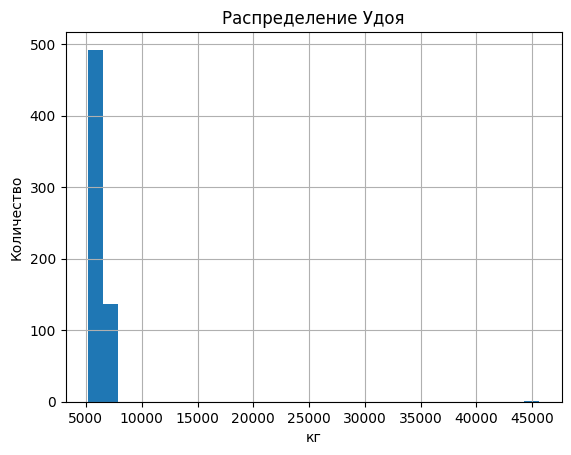

In [35]:
ferma_main['Удой, кг'].hist(bins=30)
plt.title('Распределение Удоя')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

Обнаружен выброс в 45000 кг

In [36]:
ferma_main = ferma_main[ferma_main['Удой, кг'] < 45000]

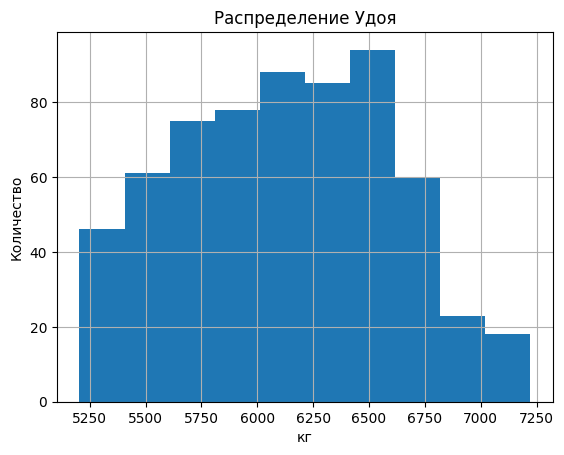

In [37]:
ferma_main['Удой, кг'].hist(bins=10)
plt.title('Распределение Удоя')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

распределение Удоя носит нормальный характер.

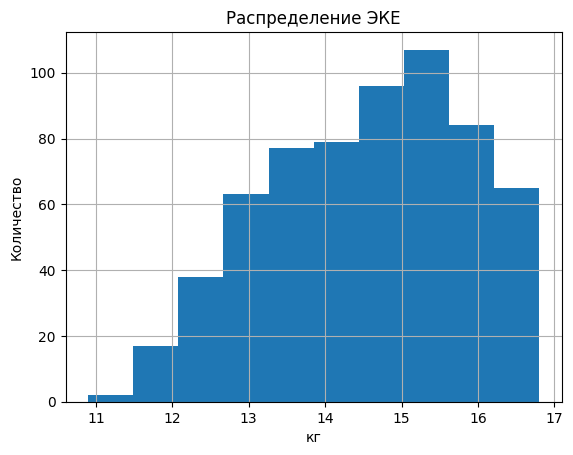

In [38]:
ferma_main['ЭКЕ'].hist(bins=10)
plt.title('Распределение ЭКЕ')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

распределение ЭКЕ носит нормальный характер с левым скосом

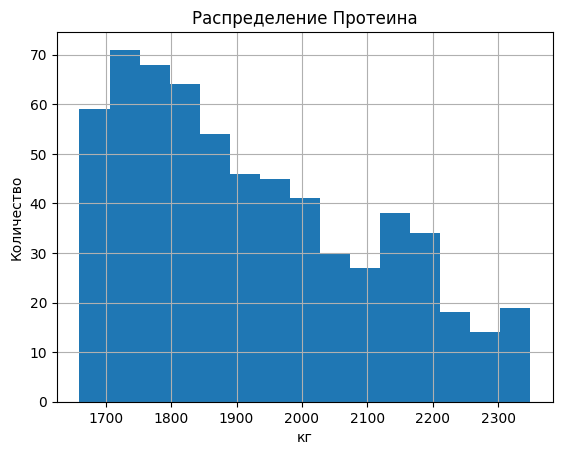

In [39]:
ferma_main['Сырой протеин, г'].hist(bins=15)
plt.title('Распределение Протеина')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

распределение Протеина носит нормальный характер с правым скосом

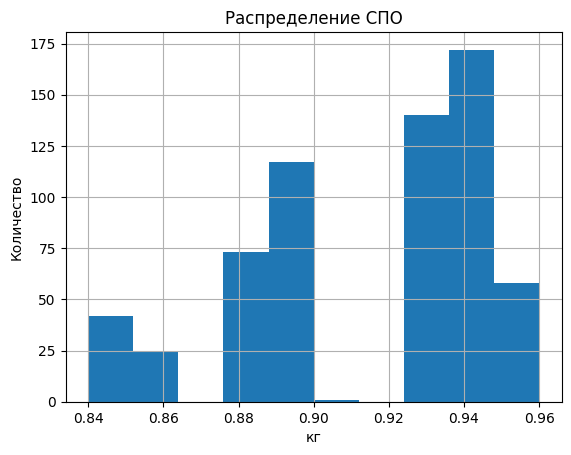

In [40]:
ferma_main['СПО'].hist(bins=10)
plt.title('Распределение СПО')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

распределение СПО носит НЕнормальный характер.
Может быть, его нужно превратить в три признака: малое соотношение (0,84-0,879); среднее (0,88-0,919); высокое (0,92-1)

пока не буду этого делать, но возможно это пригодится на этапе построения регресии

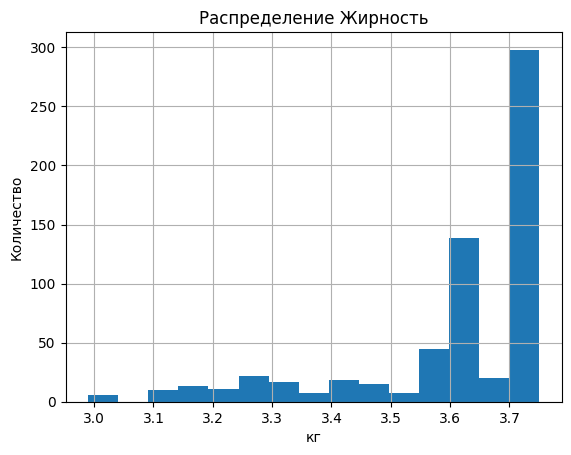

In [41]:
ferma_main['Жирность,%'].hist(bins=15)
plt.title('Распределение Жирность')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

распределение Жирности носит НЕнормальный характер с двумя пиками возле значений 3,6 и 3,7

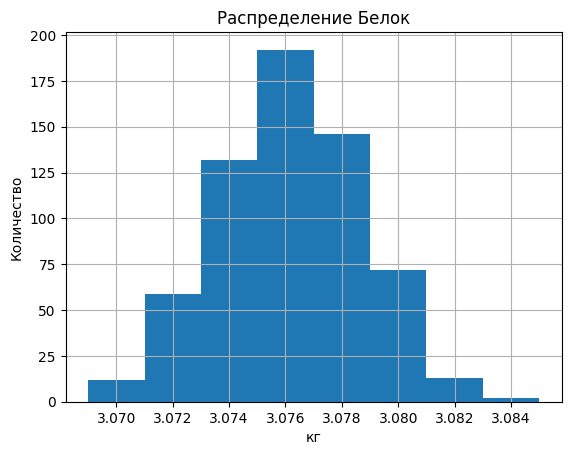

In [42]:
ferma_main['Белок,%'].hist(bins=8)
plt.title('Распределение Белок')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

распределение Белка носит нормальный характер, выбросов нет

Рассмотрим категориальные признаки

In [43]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более2лет
1,2,5529,12.8,2138,0.890,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее2лет
2,3,5810,14.0,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более2лет
3,4,5895,12.4,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более2лет
4,5,5302,12.8,1675,0.885,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее2лет


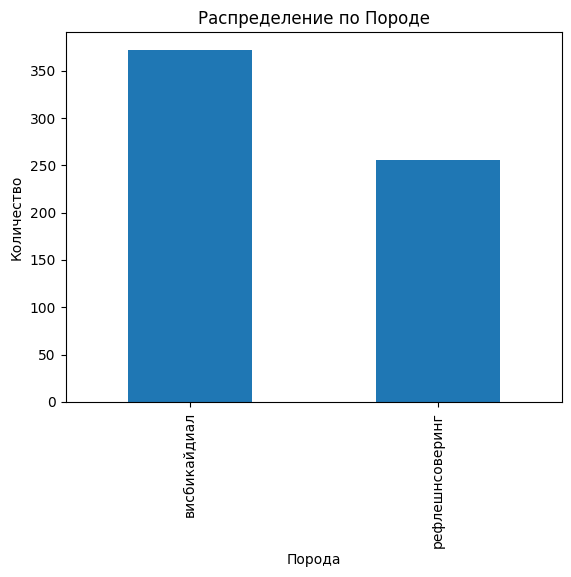

In [44]:
ax = ferma_main['Порода'].value_counts().plot.bar()
plt.title('Распределение по Породе')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.show()

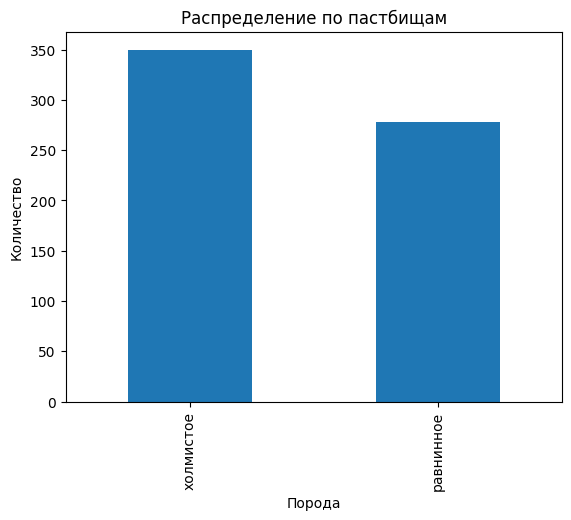

In [45]:
ax = ferma_main['Тип пастбища'].value_counts().plot.bar()
plt.title('Распределение по пастбищам')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.show()

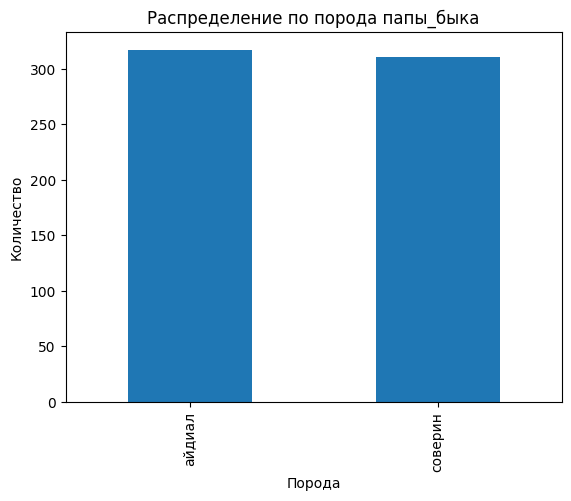

In [46]:
ax = ferma_main['порода папы_быка'].value_counts().plot.bar()
plt.title('Распределение по порода папы_быка')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.show()

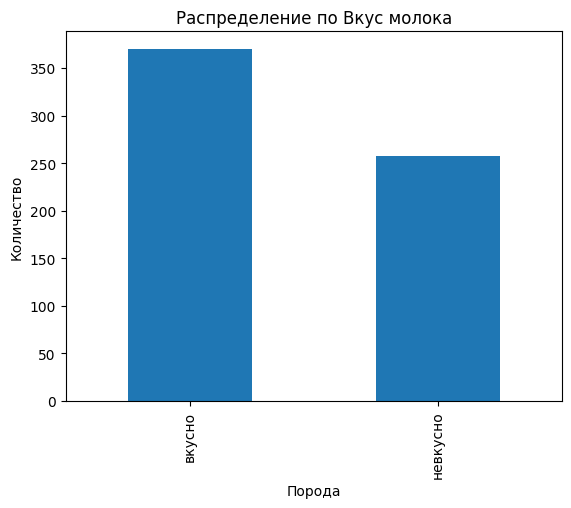

In [47]:
ax = ferma_main['Вкус молока'].value_counts().plot.bar()
plt.title('Распределение по Вкус молока')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.show()

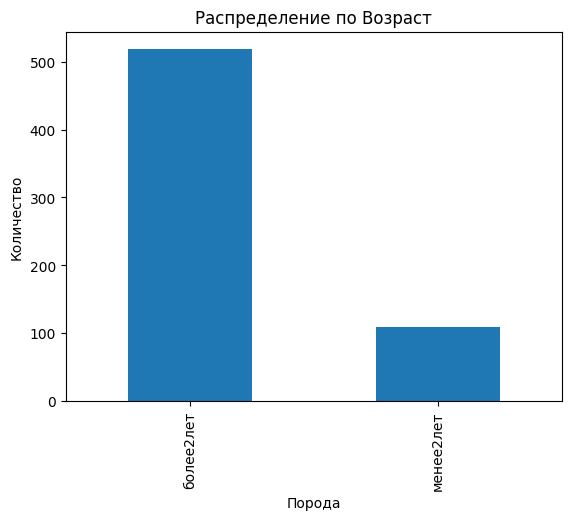

In [48]:
ax = ferma_main['Возраст'].value_counts().plot.bar()
plt.title('Распределение по Возраст')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.show()

In [49]:
## Корреляционный анализ

Поскольку факторы имеют относительно нормальное распределение - Построим матрицу корреляций Спирмана

<Axes: >

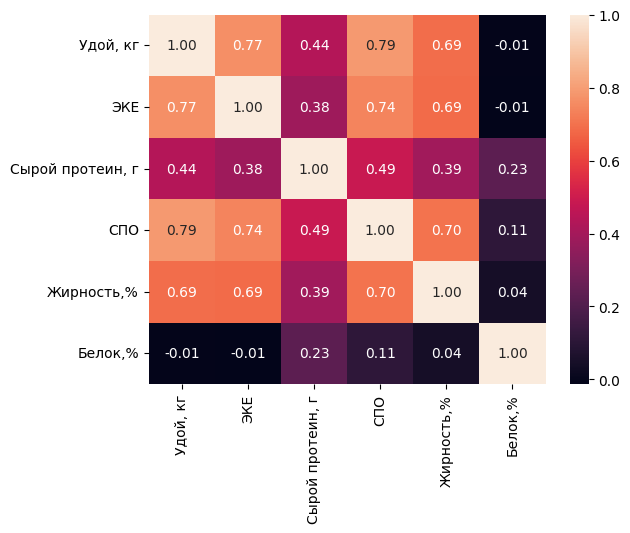

In [50]:
sns.heatmap(ferma_main[['Удой, кг', 'ЭКЕ', 'Сырой протеин, г', 'СПО', 'Жирность,%', 'Белок,%']].corr(method="spearman"), annot=True, fmt='.2f')

In [51]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой, кг          628 non-null    int64  
 2   ЭКЕ               628 non-null    float64
 3   Сырой протеин, г  628 non-null    int64  
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип пастбища      628 non-null    object 
 7   порода папы_быка  628 non-null    object 
 8   Жирность,%        628 non-null    float64
 9   Белок,%           628 non-null    float64
 10  Вкус молока       628 non-null    object 
 11  Возраст           628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


Между Удоем и ЭКЕ сильная взаимосвязь, рассмотрим графики рассеяния

<Axes: xlabel='Удой, кг', ylabel='ЭКЕ'>

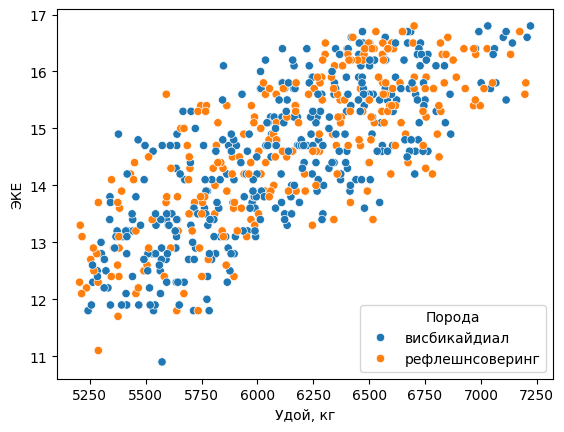

In [52]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="ЭКЕ", hue = "Порода")

Обе породы одинаоково реагируют на ЭКЕ, увеличивая Удой с увеличением ЭКЕ

<Axes: xlabel='Удой, кг', ylabel='ЭКЕ'>

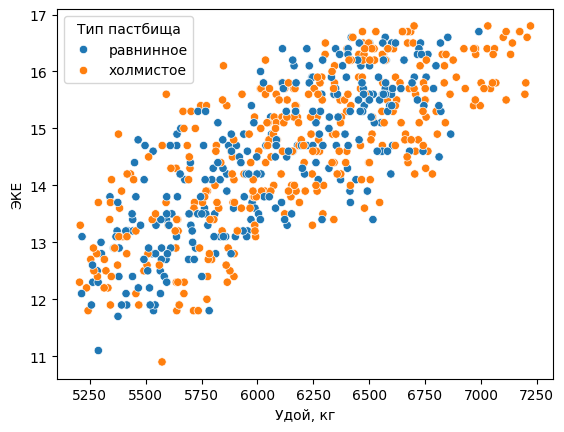

In [53]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="ЭКЕ", hue = "Тип пастбища")

Тип пастбища также не влияет на ЭКЕ, увеличивая Удой с увеличением ЭКЕ

<Axes: xlabel='Удой, кг', ylabel='ЭКЕ'>

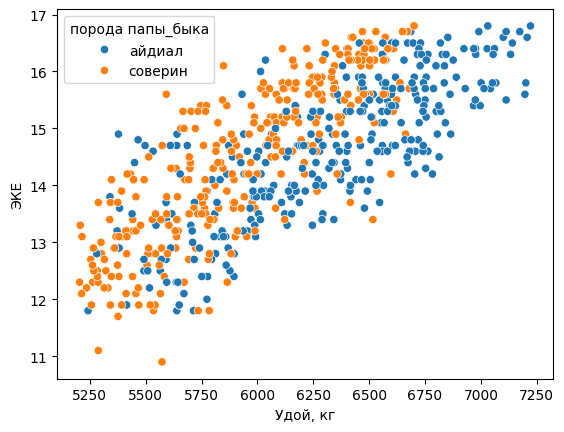

In [54]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="ЭКЕ", hue = "порода папы_быка")

Потомство Айдала более чувствительно к ЭКЕ, увеличивая Удой с большим ускорением с увеличением ЭКЕ

<Axes: xlabel='Удой, кг', ylabel='ЭКЕ'>

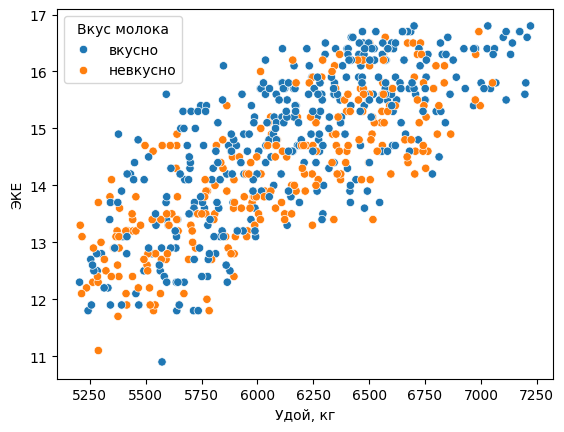

In [55]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="ЭКЕ", hue = "Вкус молока")

Вкус молока не чувствительно к ЭКЕ

<Axes: xlabel='Удой, кг', ylabel='ЭКЕ'>

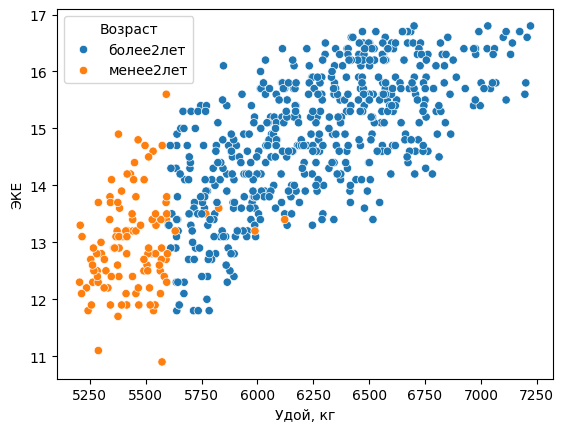

In [56]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="ЭКЕ", hue = "Возраст")

коровы до двух лет дают молока в диапазоне 5250 - 5500 независимо от ЭКЕ, тогда как более старшие особи дают не менее 5500 и прослеживается положительная связь с ЭКЕ

<Axes: xlabel='Удой, кг', ylabel='Сырой протеин, г'>

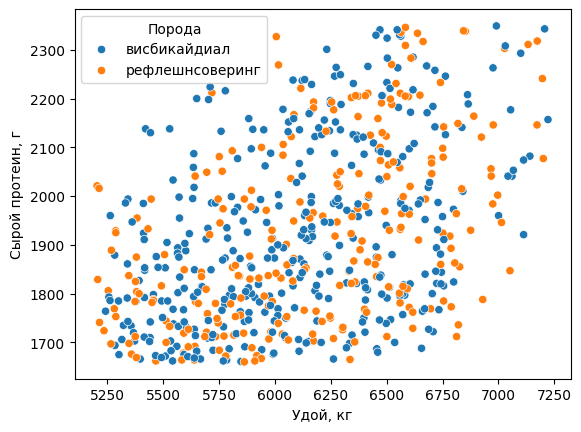

In [57]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Сырой протеин, г", hue = "Порода")

<Axes: xlabel='Удой, кг', ylabel='Сырой протеин, г'>

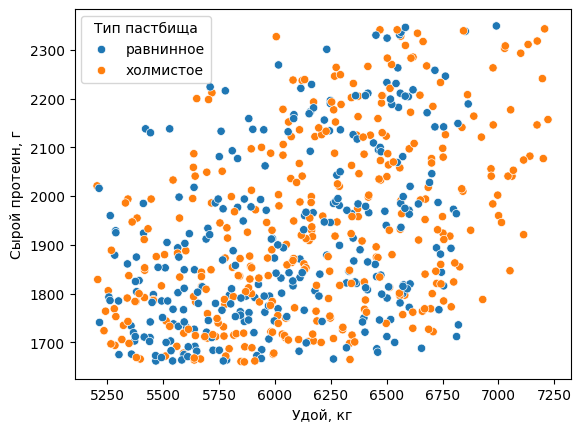

In [58]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Сырой протеин, г", hue = "Тип пастбища")

<Axes: xlabel='Удой, кг', ylabel='Сырой протеин, г'>

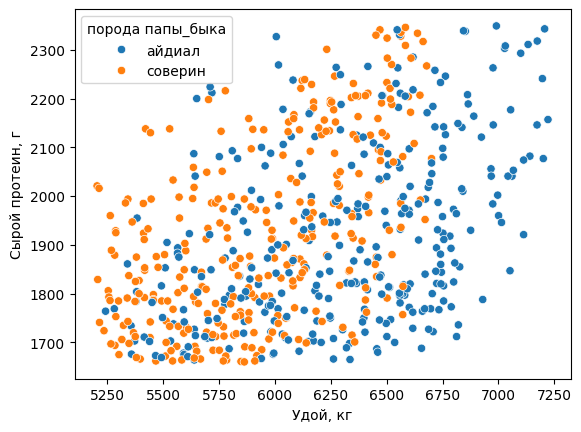

In [59]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Сырой протеин, г", hue = "порода папы_быка")

<Axes: xlabel='Удой, кг', ylabel='Сырой протеин, г'>

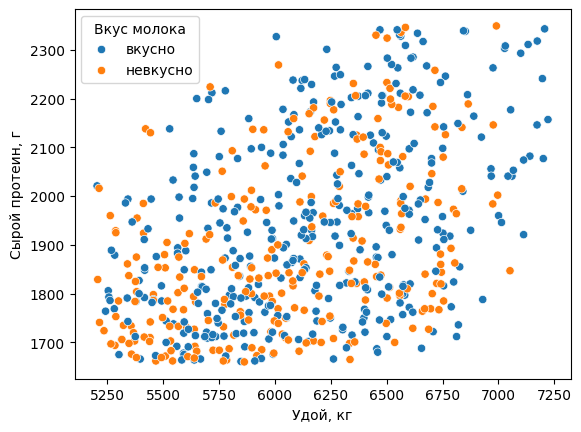

In [60]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Сырой протеин, г", hue = "Вкус молока")

Взаимосвязь между протейином и Удоем есть, но она слабая. При этом нет взаимосвязи между Протеином и категориальными переменными (Вкус молока, Родитель, Тип пастбища, Порода) - независимо от внешних условий увеличение протина в некоторой степени увеличивает Удой

<Axes: xlabel='Удой, кг', ylabel='Сырой протеин, г'>

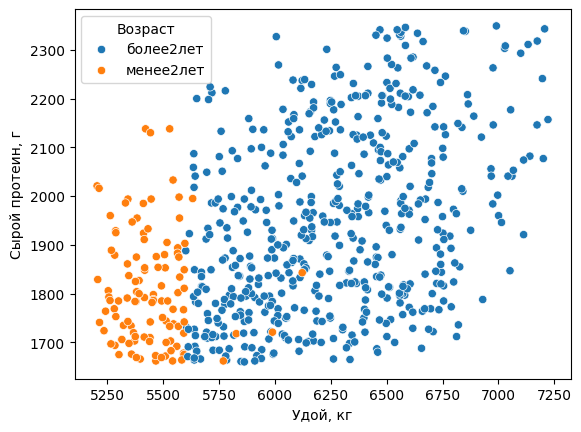

In [61]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Сырой протеин, г", hue = "Возраст")

как и ЭКЕ протеин не способствует удою у молодых особей и способствует у более старших

In [62]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="СПО", hue = "Порода")

<Axes: xlabel='Удой, кг', ylabel='СПО'>

Error in callback <function flush_figures at 0x0000024BC1083670> (for post_execute):



KeyboardInterrupt



<Axes: xlabel='Удой, кг', ylabel='СПО'>

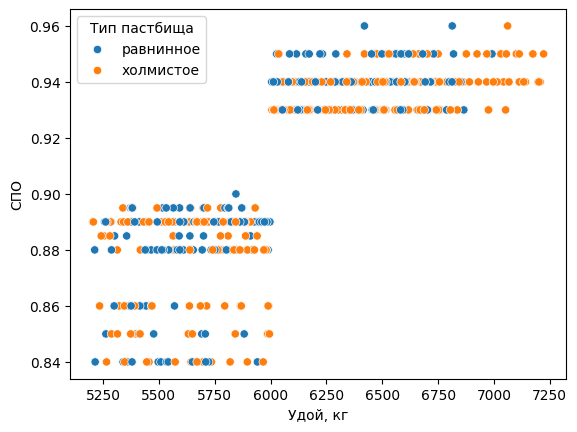

In [63]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="СПО", hue = "Тип пастбища")

<Axes: xlabel='Удой, кг', ylabel='СПО'>

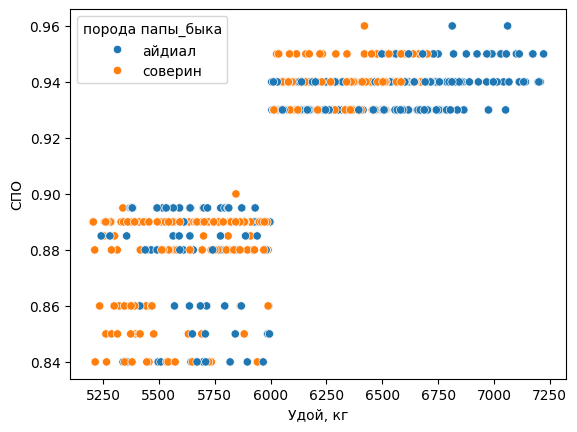

In [64]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="СПО", hue = "порода папы_быка")

In [65]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="СПО", hue = "Вкус молока")

<Axes: xlabel='Удой, кг', ylabel='СПО'>

Error in callback <function flush_figures at 0x0000024BC1083670> (for post_execute):


KeyboardInterrupt: 

<Axes: xlabel='Удой, кг', ylabel='СПО'>

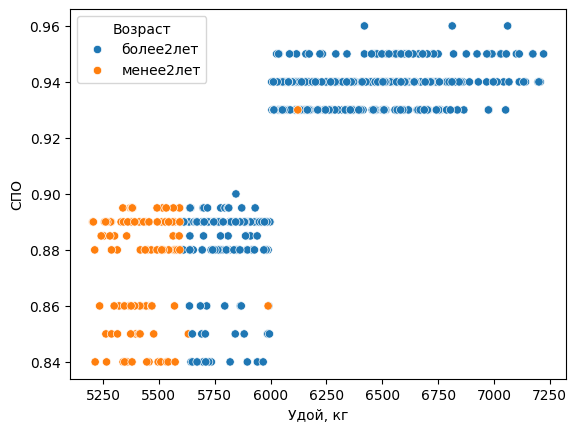

In [66]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="СПО", hue = "Возраст")

СПО изначально имеет НЕнормальное распределение и по сути подразделяется на две группы: малое соотношение (0,84-0,919); высокое (0,92-1) В общем-то зависимость видна: более высокое СПО способствуеи более высоким Удоям, но как и все остальные признаки на молодых особей он влияние не оказывает

<Axes: xlabel='Удой, кг', ylabel='Жирность,%'>

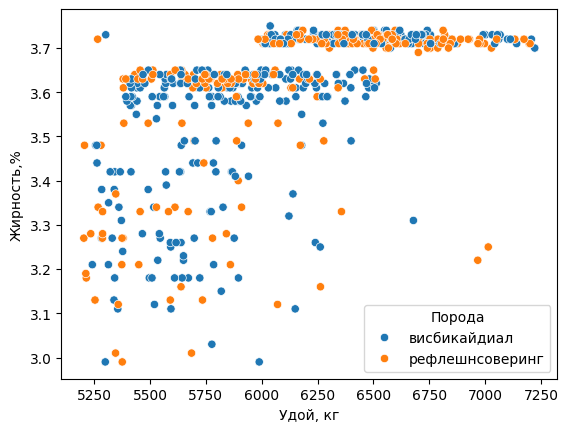

In [67]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Жирность,%", hue = "Порода")

<Axes: xlabel='Удой, кг', ylabel='Жирность,%'>

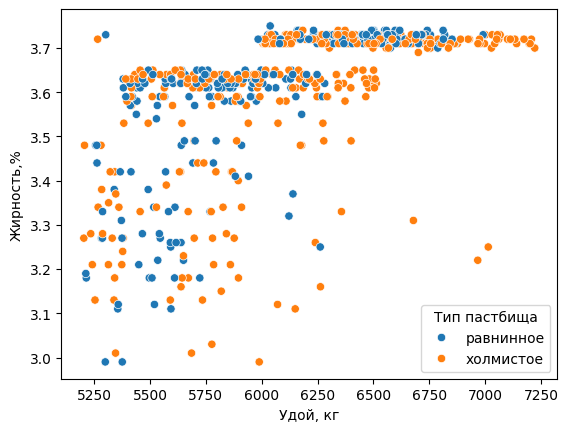

In [68]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Жирность,%", hue = "Тип пастбища")

<Axes: xlabel='Удой, кг', ylabel='Жирность,%'>

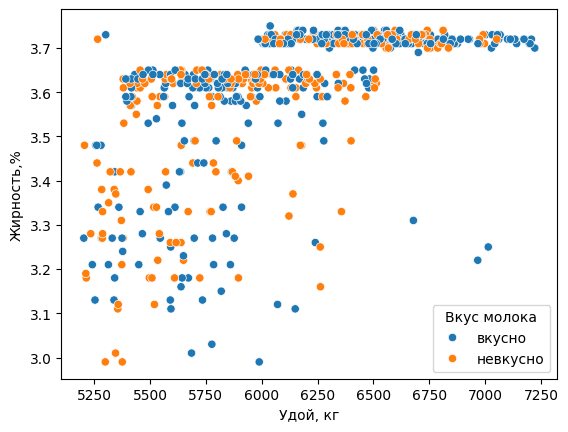

In [69]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Жирность,%", hue = "Вкус молока")

По Жирности молоко делится практически на две категории 3,6 и 3,7 (остальное скорее отклонения) В общем-то зависимость видна: более высокая Жирность способствуеи более высоким Удоям

<Axes: xlabel='Удой, кг', ylabel='Жирность,%'>

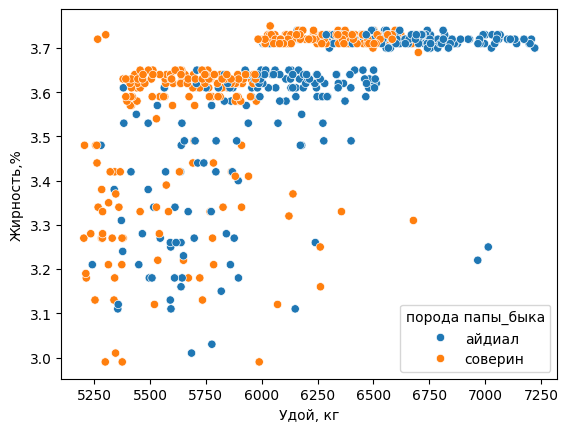

In [70]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Жирность,%", hue = "порода папы_быка")

Видна зависимость жирности молока от Родителя. Потомство Айдала более чувтсвительно к Удоям в завитсимости от Жирности

<Axes: xlabel='Удой, кг', ylabel='Жирность,%'>

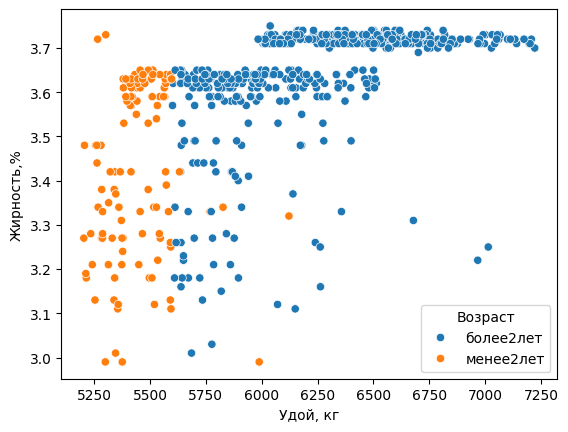

In [71]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Жирность,%", hue = "Возраст")

<Axes: xlabel='Удой, кг', ylabel='Белок,%'>

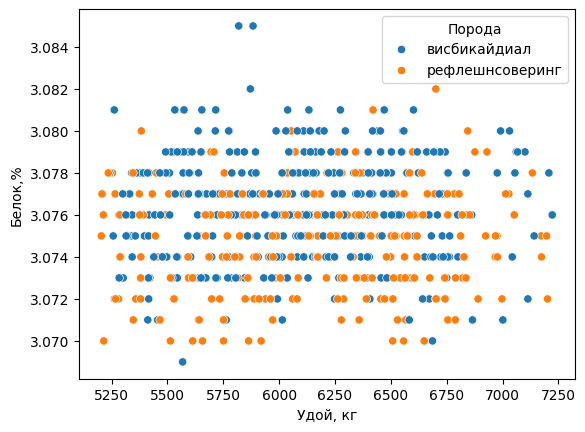

In [72]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Белок,%", hue = "Порода")

<Axes: xlabel='Удой, кг', ylabel='Белок,%'>

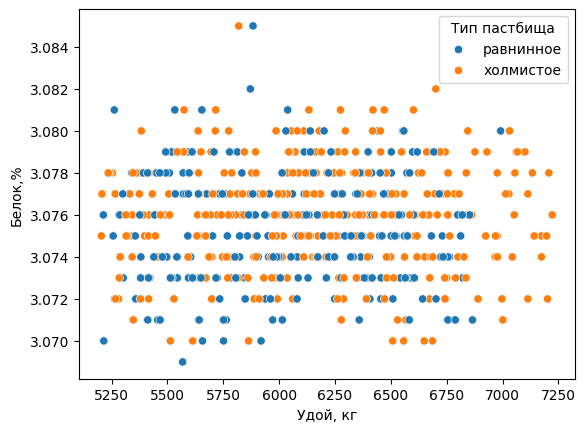

In [73]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Белок,%", hue = "Тип пастбища")

<Axes: xlabel='Удой, кг', ylabel='Белок,%'>

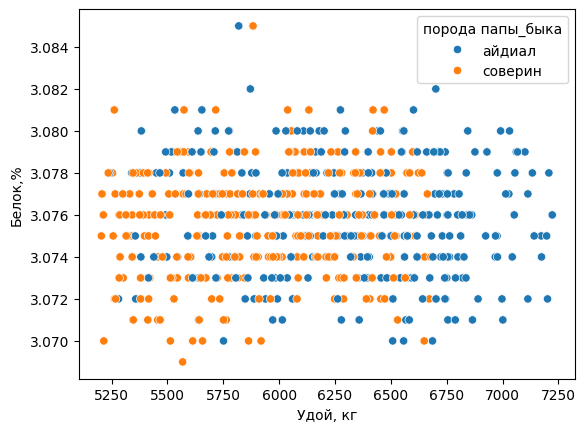

In [74]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Белок,%", hue = "порода папы_быка")

<Axes: xlabel='Удой, кг', ylabel='Белок,%'>

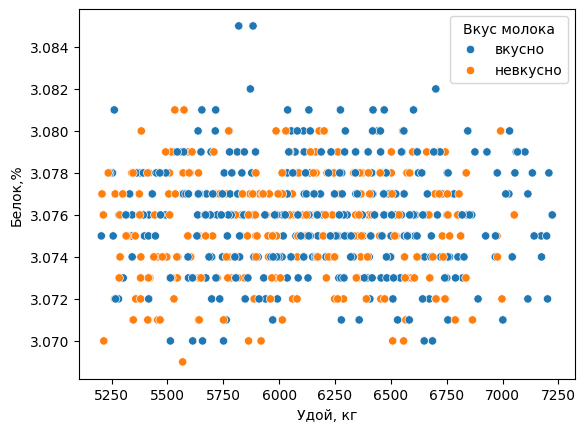

In [75]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Белок,%", hue = "Вкус молока")

<Axes: xlabel='Удой, кг', ylabel='Белок,%'>

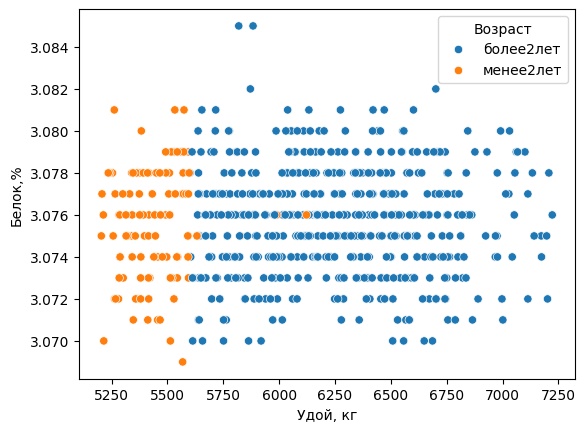

In [76]:
sns.scatterplot(data=ferma_main, x="Удой, кг", y="Белок,%", hue = "Возраст")

Содержание Белка никак не связано с Удоями

Таким образом можно сделать следующие выводы: - никак не связан с целевой параметр Белок - он не влияет на Удой - имеет сильную и относительно линейную связь (с большим стандартным отклонением) с Удоями параметр ЭКЕ - слабую и нелинейную зависимость с целевой переменной имеет параметр Протеин - также два признака Жирность и СПО имеют нелинейную зависимость, т.к. распределение этих параметров ненормальное

Мультиколлениарность не наблюдается. Максимальная корреляция между признаками - между признаками СПО и ЭКЕ 0,75

Для построения модели целесообразно использовать следующие признаки: - не брать в расчет характеристика молока: Белок, Жирность, Вкус молока
отобрать количественные характеристики: ЭКЕ, Протеин, СПО (хотя у него и нелиненая завиимость)
отобрать категориальные признаки: Порода, Тип пастбища, порода папы_быка, Возраст

## Обучение модели линейной регрессии

In [77]:
df = ferma_main[ferma_main.columns]

In [78]:
df.describe(include = 'object')

,Порода,Тип пастбища,порода папы_быка,Вкус молока,Возраст
count,628,628,628,628,628
unique,2,2,2,2,2
top,висбикайдиал,холмистое,айдиал,вкусно,более2лет
freq,372,350,317,370,518


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой, кг          628 non-null    int64  
 2   ЭКЕ               628 non-null    float64
 3   Сырой протеин, г  628 non-null    int64  
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип пастбища      628 non-null    object 
 7   порода папы_быка  628 non-null    object 
 8   Жирность,%        628 non-null    float64
 9   Белок,%           628 non-null    float64
 10  Вкус молока       628 non-null    object 
 11  Возраст           628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


In [80]:
RANDOM_STATE = 42

X = df.drop('Удой, кг', axis=1)
y = df['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471 entries, 508 to 103
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   ЭКЕ               471 non-null    float64
 2   Сырой протеин, г  471 non-null    int64  
 3   СПО               471 non-null    float64
 4   Порода            471 non-null    object 
 5   Тип пастбища      471 non-null    object 
 6   порода папы_быка  471 non-null    object 
 7   Жирность,%        471 non-null    float64
 8   Белок,%           471 non-null    float64
 9   Вкус молока       471 non-null    object 
 10  Возраст           471 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 44.2+ KB


In [81]:
#pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: D:\YP\practicum\practicum_env\Scripts\python.exe -m pip install --upgrade pip


In [94]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г', 'СПО']


#категориальные
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'Возраст_менее2лет'], dtype=object)

In [95]:
#количественные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [96]:
#соединяем
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [97]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions1 = model_lr.predict(X_test)

In [98]:
r2 = r2_score(y_test, predictions1)  
r2

0.7844078173416966

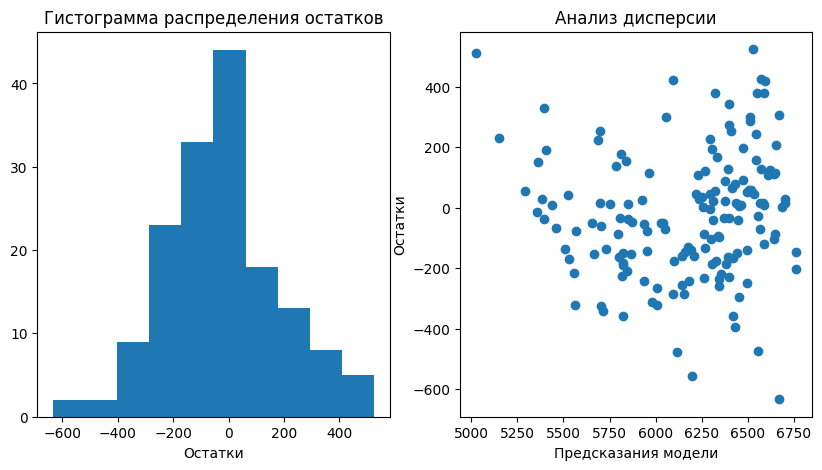

In [99]:
# проведите анализ остатков
# перед этим рассчитайте остатки
residuals = y_test - predictions1

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions1, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Модель имеет умеренную предсказательную способность с коэффициентом детерминации 0,78
    остатки имеюют нормальное распределение, и почти не имеют смещения, что означает, что модель адекватно оценивает в своих прогнозах относительно реального объема Удоя
    разброс остатков имеет постоянный характер
    
    Одним из возмождных вариантов повышения качества модели:
    - включить в модель СПО как категориальный признак
    - взять квадрат ЭКЕ
    - совсем не использовались данные из остальных двух таблиц

## Обучение модели линейной регрессии 2

In [100]:
df = ferma_main[ferma_main.columns]
#df = ferma_main.drop(['Белок,%'], axis= 1)
#df = df[df['Возраст']!='менее2лет']
#df = df.drop(['Возраст'], axis= 1)
#df = df.drop(['id'], axis= 1)

df.loc[df['СПО']<0.92, ['СПО']] = 0
df.loc[df['СПО']>=0.92, ['СПО']] = 1

df['ЭКЕ'] = df['ЭКЕ']**2
#df['Жирность,%'] = df['Жирность,%']**2

df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,201.64,1743,0.0,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более2лет
1,2,5529,163.84,2138,0.0,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее2лет
2,3,5810,196.00,1854,0.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более2лет
3,4,5895,153.76,2012,0.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более2лет
4,5,5302,163.84,1675,0.0,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее2лет


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой, кг          628 non-null    int64  
 2   ЭКЕ               628 non-null    float64
 3   Сырой протеин, г  628 non-null    int64  
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип пастбища      628 non-null    object 
 7   порода папы_быка  628 non-null    object 
 8   Жирность,%        628 non-null    float64
 9   Белок,%           628 non-null    float64
 10  Вкус молока       628 non-null    object 
 11  Возраст           628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


<Axes: xlabel='Удой, кг', ylabel='ЭКЕ'>

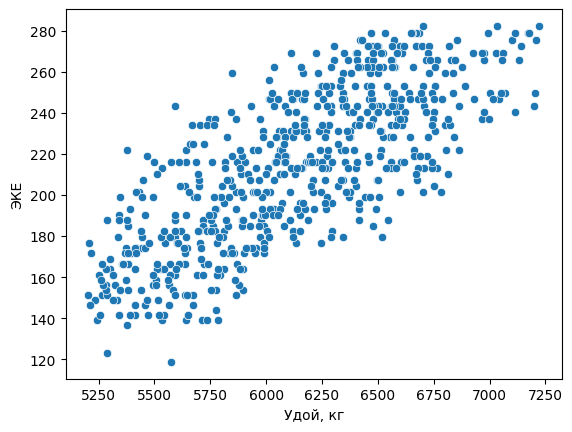

In [102]:
sns.scatterplot(data=df, x="Удой, кг", y="ЭКЕ")

In [103]:
RANDOM_STATE = 42

X = df.drop('Удой, кг', axis=1)
y = df['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471 entries, 508 to 103
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   ЭКЕ               471 non-null    float64
 2   Сырой протеин, г  471 non-null    int64  
 3   СПО               471 non-null    float64
 4   Порода            471 non-null    object 
 5   Тип пастбища      471 non-null    object 
 6   порода папы_быка  471 non-null    object 
 7   Жирность,%        471 non-null    float64
 8   Белок,%           471 non-null    float64
 9   Вкус молока       471 non-null    object 
 10  Возраст           471 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 44.2+ KB


In [108]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г']


#категориальные
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Возраст_менее2лет'],
      dtype=object)

In [109]:
#количественные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [110]:
#соединяем
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [111]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions2 = model_lr.predict(X_test)

In [112]:
r2 = r2_score(y_test, predictions2)  
r2

0.8180879926867501

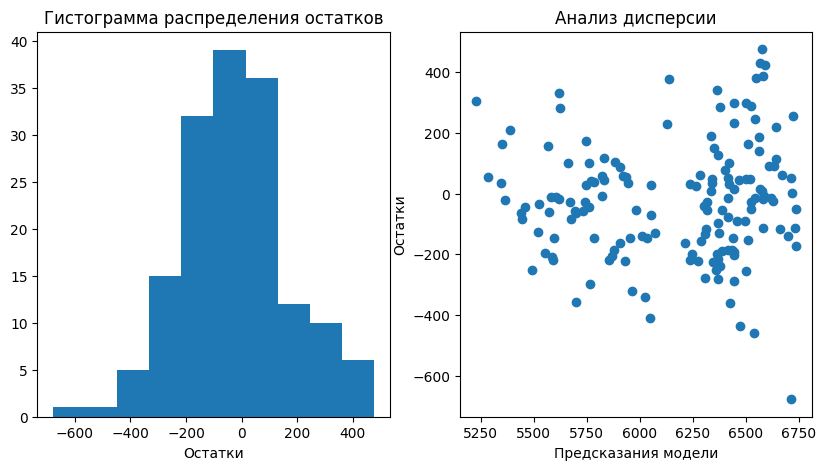

In [113]:
# проведите анализ остатков
# перед этим рассчитайте остатки2
residuals = y_test - predictions2
2
# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions2, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

R2 увеличился и стал 0,82 Распределение остатков: - смещение отсутствет - распределение остатков равномерное

## Обучение модели линейной регрессии 3

In [114]:
df = ferma_main[ferma_main.columns]

df.loc[df['СПО']<0.92, ['СПО']] = 0
df.loc[df['СПО']>=0.92, ['СПО']] = 1

df['ЭКЕ'] = df['ЭКЕ']**2

df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,201.64,1743,0.0,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более2лет
1,2,5529,163.84,2138,0.0,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее2лет
2,3,5810,196.00,1854,0.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более2лет
3,4,5895,153.76,2012,0.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более2лет
4,5,5302,163.84,1675,0.0,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее2лет


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой, кг          628 non-null    int64  
 2   ЭКЕ               628 non-null    float64
 3   Сырой протеин, г  628 non-null    int64  
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип пастбища      628 non-null    object 
 7   порода папы_быка  628 non-null    object 
 8   Жирность,%        628 non-null    float64
 9   Белок,%           628 non-null    float64
 10  Вкус молока       628 non-null    object 
 11  Возраст           628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


In [116]:
ferma_dad.head()

,id,Имя Папы
0,1,буйный
1,2,соловчик
2,3,барин
3,4,буйный
4,5,барин


In [117]:
df = df.merge(ferma_dad, how  ='inner', on = 'id')

In [118]:
df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,201.64,1743,0.0,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более2лет,буйный
1,2,5529,163.84,2138,0.0,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее2лет,соловчик
2,3,5810,196.00,1854,0.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более2лет,барин
3,4,5895,153.76,2012,0.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более2лет,буйный
4,5,5302,163.84,1675,0.0,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее2лет,барин


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой, кг          628 non-null    int64  
 2   ЭКЕ               628 non-null    float64
 3   Сырой протеин, г  628 non-null    int64  
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип пастбища      628 non-null    object 
 7   порода папы_быка  628 non-null    object 
 8   Жирность,%        628 non-null    float64
 9   Белок,%           628 non-null    float64
 10  Вкус молока       628 non-null    object 
 11  Возраст           628 non-null    object 
 12  Имя Папы          628 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 63.9+ KB


In [120]:
RANDOM_STATE = 42

X = df.drop('Удой, кг', axis=1)
y = df['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471 entries, 507 to 102
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   ЭКЕ               471 non-null    float64
 2   Сырой протеин, г  471 non-null    int64  
 3   СПО               471 non-null    float64
 4   Порода            471 non-null    object 
 5   Тип пастбища      471 non-null    object 
 6   порода папы_быка  471 non-null    object 
 7   Жирность,%        471 non-null    float64
 8   Белок,%           471 non-null    float64
 9   Вкус молока       471 non-null    object 
 10  Возраст           471 non-null    object 
 11  Имя Папы          471 non-null    object 
dtypes: float64(4), int64(2), object(6)
memory usage: 47.8+ KB


In [124]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г']


#категориальные
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [125]:
#количественные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [126]:
#соединяем
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [127]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions3 = model_lr.predict(X_test)

In [128]:
r2 = r2_score(y_test, predictions3)  
r2

0.8247542745210408

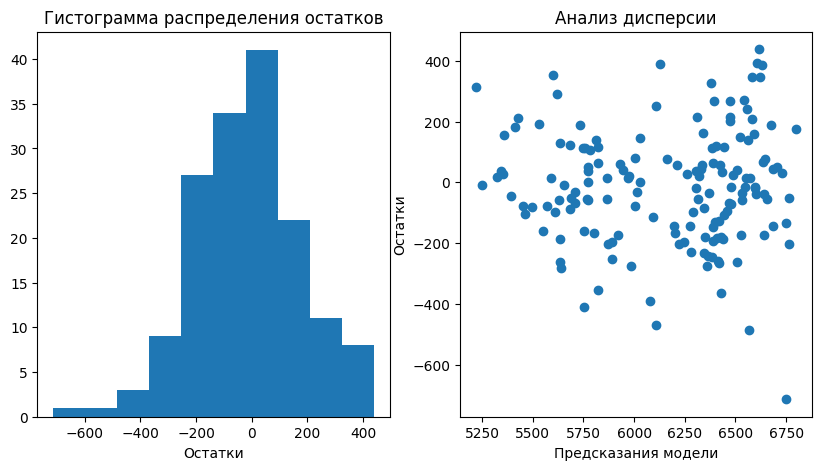

In [129]:
# проведите анализ остатков
# перед этим рассчитайте остатки
residuals = y_test - predictions3

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions3, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

R2 увеличился незначительно и стал 0,82 Распределение остатков: - смещения практически нет, то есть модель примерно адекватно оценивает удои - распределение остатков стало более равномерно

In [130]:
model_lr.coef_

array([  14.91963448,   50.94331021,   44.03330527,  353.77982896,
        302.17959627,  333.92915102,   24.6844087 , -192.54870875,
        162.38779236,   52.03531718])

In [131]:
X_train.head()

,Порода_рефлешнсоверинг,Тип пастбища_холмистое,порода папы_быка_соверин,СПО_1.0,Имя Папы_буйный,Имя Папы_геркулес,Имя Папы_соловчик,Возраст_менее2лет,ЭКЕ,"Сырой протеин, г"
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.577968,1.079523
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.511438,-0.196920
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.082269,-1.386085
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.150235,0.752230
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.102358,0.828598


In [132]:
def metrics(a, b, c):
    mae = mean_absolute_error(b, c)
    mse = mean_squared_error(b, c)
    rmse = np.sqrt(mse)
    print(a, ', mae:',mae, ', mse:', mse, ', rmse:', rmse)

In [133]:
metrics('Модель1',y_test, predictions1)

Модель1 , mae: 164.2419446347493 , mse: 43887.015009660536 , rmse: 209.49227911706086


In [134]:
metrics('Модель2',y_test, predictions2)

Модель2 , mae: 149.03965222364613 , mse: 37030.91131113697 , rmse: 192.43417396901458


In [135]:
metrics('Модель3',y_test, predictions3)

Модель3 , mae: 146.16302445362308 , mse: 35673.88988618191 , rmse: 188.8753289505591


In [137]:
print('95% доверительный интервал =', st.norm.interval(0.95, loc=np.mean(predictions3), scale=st.sem(predictions3)))

95% доверительный интервал = (6092.340075854288, 6221.3750700583805)


для более точного прогноза удоя будем по верхней границе доверительного интервала - 6221

Третья модель определенно лучше всех. В среднем она ошибается на 189 кг удоя при прогнозирования

In [138]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_белок,%",Возраст
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более2лет
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.081,менее2лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более2лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более2лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более2лет


In [139]:
df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,201.64,1743,0.0,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более2лет,буйный
1,2,5529,163.84,2138,0.0,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее2лет,соловчик
2,3,5810,196.00,1854,0.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более2лет,барин
3,4,5895,153.76,2012,0.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более2лет,буйный
4,5,5302,163.84,1675,0.0,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее2лет,барин


In [140]:
cow_buy_new = cow_buy[cow_buy.columns]
cow_buy_new = cow_buy_new.rename(columns={'Текущая_жирность,%': 'Жирность,%', 'Имя_папы': 'Имя Папы'})

data_describe = df.describe(include=[object])
data_describe

,Порода,Тип пастбища,порода папы_быка,Вкус молока,Возраст,Имя Папы
count,628,628,628,628,628,628
unique,2,2,2,2,2,4
top,висбикайдиал,холмистое,айдиал,вкусно,более2лет,барин
freq,372,350,317,370,518,240


In [141]:
df.describe()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,"Жирность,%","Белок,%"
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,213.357357,1923.759554,0.589172,3.604268,3.075670
std,181.475367,475.857053,37.421299,182.832816,0.492376,0.168093,0.002551
min,1.000000,5204.000000,118.810000,1660.000000,0.000000,2.990000,3.069000
25%,158.750000,5749.750000,182.250000,1771.750000,0.000000,3.590000,3.074000
50%,315.500000,6132.500000,216.090000,1888.000000,1.000000,3.650000,3.076000
75%,472.250000,6501.000000,243.360000,2062.250000,1.000000,3.720000,3.077000
max,629.000000,7222.000000,282.240000,2349.000000,1.000000,3.750000,3.085000


In [142]:
cow_buy_new['ЭКЕ'] = df['ЭКЕ'].mean()*1.05
cow_buy_new['СПО'] = df['СПО'].mean()*1.05
cow_buy_new['Сырой протеин, г'] = df['Сырой протеин, г'].mean()*1.05


In [143]:
df['ЭКЕ'].mean()

213.35735668789806

In [144]:
cow_buy_new['ЭКЕ']

0     224.025225
1     224.025225
2     224.025225
3     224.025225
4     224.025225
5     224.025225
6     224.025225
7     224.025225
8     224.025225
9     224.025225
10    224.025225
11    224.025225
12    224.025225
13    224.025225
14    224.025225
15    224.025225
16    224.025225
17    224.025225
18    224.025225
19    224.025225
Name: ЭКЕ, dtype: float64

In [145]:
cow_buy_new.loc[df['СПО']<0.92, ['СПО']] = 0
cow_buy_new.loc[df['СПО']>=0.92, ['СПО']] = 1

In [147]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г']


#категориальные

cow_buy_new_ohe = encoder.transform(cow_buy_new[cat_col_names])


encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [148]:
#количественные
cow_buy_new_scaled = scaler.transform(cow_buy_new[num_col_names])

In [149]:
#соединяем
X_test_ohe = pd.DataFrame(cow_buy_new_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(cow_buy_new_scaled, columns=num_col_names)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [150]:
# обучение модели и получение предсказаний на тестовых данных

predictions_cow_buy_new_scaled = model_lr.predict(X_test)
predictions_cow_buy_new_scaled

array([6215.76311421, 5984.55484576, 5889.84359272, 6198.93319394,
       6147.98988373, 6031.22403499, 6215.76311421, 6530.88338347,
       6243.62342168, 6006.38448519, 5950.55167715, 6577.5525727 ,
       6569.54294317, 6087.09838866, 6243.62342168, 6552.71302289,
       5950.55167715, 6385.00386394, 6177.10355451, 6501.76971268])

In [151]:
result = cow_buy[cow_buy.columns]
result['Удой, кг'] = predictions_cow_buy_new_scaled
result

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_белок,%",Возраст,"Удой, кг"
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более2лет,6215.763114
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.081,менее2лет,5984.554846
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более2лет,5889.843593
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более2лет,6198.933194
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более2лет,6147.989884
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее2лет,6031.224035
6,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более2лет,6215.763114
7,висбикайдиал,равнинное,соверин,буйный,3.57,3.079,более2лет,6530.883383
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более2лет,6243.623422
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее2лет,6006.384485


Учитывая, что задача отобрать коров с удоем не менее 6221 кг, то под этот критерий попадает всего 8 коров

## Обучение модели логистической регрессии

In [152]:
df = ferma_main[ferma_main.columns]
df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более2лет
1,2,5529,12.8,2138,0.890,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее2лет
2,3,5810,14.0,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более2лет
3,4,5895,12.4,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более2лет
4,5,5302,12.8,1675,0.885,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее2лет


In [153]:
df.loc[df['СПО']<0.92, ['СПО']] = 0
df.loc[df['СПО']>=0.92, ['СПО']] = 1

#df.loc[df['Вкус молока']=='вкусно', ['Вкус молока']] = 1
#df.loc[df['Вкус молока']=='невкусно', ['Вкус молока']] = 0

df['Вкус молока'] = df['Вкус молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

df['Вкус молока'] = df['Вкус молока'].astype(float)

#df['ЭКЕ'] = df['ЭКЕ']**2
#df['Жирность,%'] = df['Жирность,%']**2

df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.0,висбикайдиал,равнинное,айдиал,3.58,3.076,1.0,более2лет
1,2,5529,12.8,2138,0.0,висбикайдиал,равнинное,соверин,3.54,3.079,1.0,менее2лет
2,3,5810,14.0,1854,0.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0.0,более2лет
3,4,5895,12.4,2012,0.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0.0,более2лет
4,5,5302,12.8,1675,0.0,висбикайдиал,равнинное,соверин,3.73,3.073,1.0,менее2лет


In [154]:
df = df.merge(ferma_dad, how  ='inner', on = 'id')

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   Удой, кг          628 non-null    int64  
 2   ЭКЕ               628 non-null    float64
 3   Сырой протеин, г  628 non-null    int64  
 4   СПО               628 non-null    float64
 5   Порода            628 non-null    object 
 6   Тип пастбища      628 non-null    object 
 7   порода папы_быка  628 non-null    object 
 8   Жирность,%        628 non-null    float64
 9   Белок,%           628 non-null    float64
 10  Вкус молока       628 non-null    float64
 11  Возраст           628 non-null    object 
 12  Имя Папы          628 non-null    object 
dtypes: float64(5), int64(3), object(5)
memory usage: 63.9+ KB


In [156]:
df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,14.2,1743,0.0,висбикайдиал,равнинное,айдиал,3.58,3.076,1.0,более2лет,буйный
1,2,5529,12.8,2138,0.0,висбикайдиал,равнинное,соверин,3.54,3.079,1.0,менее2лет,соловчик
2,3,5810,14.0,1854,0.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0.0,более2лет,барин
3,4,5895,12.4,2012,0.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0.0,более2лет,буйный
4,5,5302,12.8,1675,0.0,висбикайдиал,равнинное,соверин,3.73,3.073,1.0,менее2лет,барин


In [157]:
RANDOM_STATE = 42

X = df.drop('Вкус молока', axis=1)
y = df['Вкус молока']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471 entries, 507 to 102
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   Удой, кг          471 non-null    int64  
 2   ЭКЕ               471 non-null    float64
 3   Сырой протеин, г  471 non-null    int64  
 4   СПО               471 non-null    float64
 5   Порода            471 non-null    object 
 6   Тип пастбища      471 non-null    object 
 7   порода папы_быка  471 non-null    object 
 8   Жирность,%        471 non-null    float64
 9   Белок,%           471 non-null    float64
 10  Возраст           471 non-null    object 
 11  Имя Папы          471 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 47.8+ KB


In [159]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г', 'Жирность,%', 'Белок,%']


#категориальные
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [160]:
#количественные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [161]:
#соединяем
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [162]:
X_train.head()

,Порода_рефлешнсоверинг,Тип пастбища_холмистое,порода папы_быка_соверин,СПО_1.0,Имя Папы_буйный,Имя Папы_геркулес,Имя Папы_соловчик,Возраст_менее2лет,ЭКЕ,"Сырой протеин, г","Жирность,%","Белок,%"
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.502378,1.079523,0.562532,-0.679069
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.557270,-0.196920,-1.601817,-1.452568
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.125537,-1.386085,-2.563750,1.254677
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.103937,0.752230,0.081565,1.254677
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.098323,0.828598,0.201807,0.094429


In [163]:
y_train.head()

507    1.0
382    1.0
586    0.0
196    1.0
327    1.0
Name: Вкус молока, dtype: float64

In [164]:
# обучение модели и получение предсказаний на тестовых данных
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [165]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)


print('accuracy: ',round(acc ,3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

accuracy:  0.631
recall:  0.623
precision:  0.864


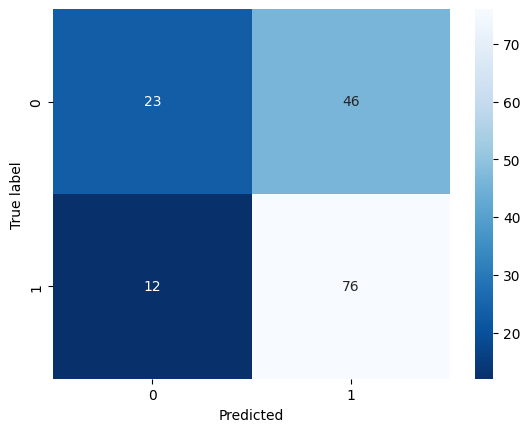

In [166]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Матрица ошибок говорит о том, что модель ошибочно предсказывает:
    - что молоко будет вкусным (1) (а на самом деле Домик в деревне (0)) в 49 случаях - False Positive - ошибка 1-ого рода
    - что молоко будет НЕвкусным (0) (а на самом деле вкусным (1)) в 12 случаях - False Negative - ошибка 2-ого рода
   
    Учитывая постановку задачи, фермеру важно, чтобы молоко было вкусным, поэтому наиболее критичным представляются ошибки первого рода
    Соответственно за мнимизацию ошибок первого рода отвечает метрика precision - и она у нас достаточно высока 86%, то есть в 14% модель считает ошибочно что молоко является вкусным

In [167]:
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head())

     y_valid   y_proba
85       1.0  0.855667
51       1.0  0.842247
66       1.0  0.838997
110      1.0  0.835898
147      1.0  0.812489


In [168]:
thresholds = [round(i,2) for i in np.linspace(0.65,0.85,num = 20,endpoint=False)]
print(thresholds) 

[0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84]


In [169]:
# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавьте столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x > i else 0 )

# выведем 5 случайных строк
#print(data.sample(5))

In [170]:
porog = []
porog = pd.DataFrame(columns=['Порог', 'Precision'])

rw = 0
for i in data.columns[2:]:
    precision = precision_score(data['y_valid'],data[i])
    porog.loc[rw] = [i, precision]
    rw = rw+1
porog

,Порог,Precision
0,y_pred_0.65,0.761905
1,y_pred_0.66,0.758065
2,y_pred_0.67,0.785714
3,y_pred_0.68,0.773585
4,y_pred_0.69,0.816327
5,y_pred_0.7,0.840909
6,y_pred_0.71,0.820513
7,y_pred_0.72,0.837838
8,y_pred_0.73,0.833333
9,y_pred_0.74,0.884615


Получается, оптимальный порог = 0,8, при котором минимизируется критическая для нас ошибка первого рода
    
    Теперь бы нам необходимо спрогнозировать вкус молока у покупаемых коров и применить в том числе полученный порог

In [171]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_белок,%",Возраст
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более2лет
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.081,менее2лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более2лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более2лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более2лет


In [172]:
df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,14.2,1743,0.0,висбикайдиал,равнинное,айдиал,3.58,3.076,1.0,более2лет,буйный
1,2,5529,12.8,2138,0.0,висбикайдиал,равнинное,соверин,3.54,3.079,1.0,менее2лет,соловчик
2,3,5810,14.0,1854,0.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0.0,более2лет,барин
3,4,5895,12.4,2012,0.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0.0,более2лет,буйный
4,5,5302,12.8,1675,0.0,висбикайдиал,равнинное,соверин,3.73,3.073,1.0,менее2лет,барин


In [173]:
cow_buy_new = cow_buy[cow_buy.columns]
cow_buy_new = cow_buy_new.rename(columns={'Текущая_жирность,%': 'Жирность,%', 'Имя_папы': 'Имя Папы', 'Текущий_белок,%': 'Белок,%'})

data_describe = df.describe(include=[object])
data_describe

,Порода,Тип пастбища,порода папы_быка,Возраст,Имя Папы
count,628,628,628,628,628
unique,2,2,2,2,4
top,висбикайдиал,холмистое,айдиал,более2лет,барин
freq,372,350,317,518,240


In [174]:
df.describe()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,"Жирность,%","Белок,%",Вкус молока
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.589172,3.604268,3.075670,0.589172
std,181.475367,475.857053,1.301777,182.832816,0.492376,0.168093,0.002551,0.492376
min,1.000000,5204.000000,10.900000,1660.000000,0.000000,2.990000,3.069000,0.000000
25%,158.750000,5749.750000,13.500000,1771.750000,0.000000,3.590000,3.074000,0.000000
50%,315.500000,6132.500000,14.700000,1888.000000,1.000000,3.650000,3.076000,1.000000
75%,472.250000,6501.000000,15.600000,2062.250000,1.000000,3.720000,3.077000,1.000000
max,629.000000,7222.000000,16.800000,2349.000000,1.000000,3.750000,3.085000,1.000000


In [175]:
cow_buy_new['ЭКЕ'] = df['ЭКЕ'].mean()*1.05
cow_buy_new['СПО'] = df['СПО'].mean()*1.05
cow_buy_new['Сырой протеин, г'] = df['Сырой протеин, г'].mean()*1.05

In [176]:
cow_buy_new.loc[df['СПО']<0.92, ['СПО']] = 0
cow_buy_new.loc[df['СПО']>=0.92, ['СПО']] = 1

#cow_buy_new['ЭКЕ'] = df['ЭКЕ']**2
#cow_buy_new['Жирность,%'] = df['Жирность,%']**2

cow_buy_new.describe()

,"Жирность,%","Белок,%",ЭКЕ,СПО,"Сырой протеин, г"
count,20.000000,20.000000,2.000000e+01,20.000000,2.000000e+01
mean,3.577500,3.069500,1.527616e+01,0.450000,2.019948e+03
std,0.126818,0.010339,1.822504e-15,0.510418,4.665609e-13
min,3.340000,3.046000,1.527616e+01,0.000000,2.019948e+03
25%,3.510000,3.064000,1.527616e+01,0.000000,2.019948e+03
50%,3.590000,3.074000,1.527616e+01,0.000000,2.019948e+03
75%,3.650000,3.076000,1.527616e+01,1.000000,2.019948e+03
max,3.770000,3.081000,1.527616e+01,1.000000,2.019948e+03


In [180]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г', 'Жирность,%', 'Белок,%']


#категориальные

cow_buy_new_ohe = encoder.transform(cow_buy_new[cat_col_names])


encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [181]:
#количественные
cow_buy_new_scaled = scaler.transform(cow_buy_new[num_col_names])

In [182]:
#соединяем
X_test_ohe = pd.DataFrame(cow_buy_new_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(cow_buy_new_scaled, columns=num_col_names)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [183]:
# получение предсказаний

predictions_cow_buy_new_scaled = clf.predict_proba(X_test)[:,1] > 0.8
predictions_cow_buy_new_scaled  = ['Вкусное' if x==True else 'Не вкусное' for x in predictions_cow_buy_new_scaled]
predictions_cow_buy_new_scaled

['Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное']

## Итоговые выводы

In [184]:
result['Вкус'] = predictions_cow_buy_new_scaled
result

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_белок,%",Возраст,"Удой, кг",Вкус
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более2лет,6215.763114,Вкусное
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.081,менее2лет,5984.554846,Не вкусное
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более2лет,5889.843593,Не вкусное
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более2лет,6198.933194,Не вкусное
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более2лет,6147.989884,Не вкусное
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее2лет,6031.224035,Не вкусное
6,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более2лет,6215.763114,Вкусное
7,висбикайдиал,равнинное,соверин,буйный,3.57,3.079,более2лет,6530.883383,Не вкусное
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более2лет,6243.623422,Не вкусное
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее2лет,6006.384485,Вкусное


In [185]:
result[(result['Удой, кг'] >= 6221)&(result['Вкус'] != 'Не вкусное')]

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_белок,%",Возраст,"Удой, кг",Вкус


Получается, нет коров, которые бы удовлетворяли одновременно двум параметрам (Удой больше 6221 и Вкусное молоко)

Данные состоят из трех таблиц: данные по фермерскому стаду, данные по покупаемому стаду и справочная таблица

На превом этапе была осуществлена предобработка данных:
- были проверены пропуски в таблицах и таковых обнаружено не было
- были преобразован тип данных в столбцах 'ЭКЕ', 'СПО', 'Жирность,%', 'Белок,%' с категориального на числовой формат
- в данных были удалены спецсимволы, а также категориальные столбца были приведены к нижнему регистру
- были удалены дубликаты: 5 строк из данных по фермерскому стаду и 4 - по покупаемому

На втором этапе был проведен статистический анализ данных:
- были выявлены выбросы в данных по распределению Удоя, которые были удалены
Также было выявлено:
    - никак не связан с целевой параметр Белок - он не влияет на Удой
    - имеет сильную и относительно линейную связь (с большим стандартным отклонением) с Удоями параметр ЭКЕ
    - слабую и нелинейную зависимость с целевой переменной имеет параметр Протеин
    - также два признака Жирность и СПО имеют нелинейную зависимость, т.к. распределение этих параметров ненормальное


По результатам предваорительного анализа было определено, что для построения модели целесообразно использовать следующие признаки:
- не брать в расчет параметр Белок, т.к. связи с целевой переменной практически нет
- не брать в расчет СПО, поскольку у него нелинейная заивисмость и мультиколлдинеарность с ЭКЕ
- признак вкуса не брать его т.к. в данных по покупаемому стаду нет того признака    
- в качестве признака отобрать параметр ЭКЕ
- взять в расчет параметр Протеин
- взять в расчет Жирность, хотя этот параметр и похож больше на категориальный признак (но попробуем)    

Сриде построенных линейных регрессий для прогнозирования Удоя была отобрана регрессия:
- в которую по итогу был добавлен параметр СПО, преобразованный в категориальный признак
- параметры ЭКЕ и Жирность были возведены в квадрат
- коэффициент итоговой линейной регрессии составил 0,82
- остатки регресиси распределены нормально и практически без смещений с отсутствием автокорреляции
- доверительный интервал полученых прогнозов (95%), что удои находятся в диапазоне (5368.167347966218, 6747.6949941134)

Была также построена логистическая регрессия для прогнозирования вкуса молока:
- в процессе калибровке был определен порог в размере 0,8, который сводит к минимуму ошибку прогнозирования вкуса молока 
(ошибку первого рода, при которой вкус молока прогнозируется вкусным, хотя в реальности таковым не является)

По итогу построений линейиной и логистической регрессии было выявлено, что коровы в покупаемм стаде дающие одновременно приемлемый уровень удоя (не менее 6000 кг) и при этом вкусного молока в приобретаемом стаде отсутствуют